In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import math
import os
import sys
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.interpolate import BSpline
from IPython.display import display, Markdown, Latex

In [2]:
# parameters for experiments displayed
# data types
data_types = [1, 2, 3, 4]
experiments = ['mvp', 'crossent_simp', 'crossent_comp', 'exp_simp']
turns = ['b0', 'b1', 'b2']

In [3]:
# complex expecation
class Exp_comp(nn.Module):
    def __init__(self, num_feat, num_units, num_classes, classes):
        super(Exp_comp, self).__init__()
        # print('feats %d' % num_feat)
        # print('units %d' % num_units)
        # print('num_classes %d' % num_classes)
        self.fc1 = nn.Linear(num_feat, num_units)
        self.fc2 = nn.Linear(num_units, num_units)
        self.fc3 = nn.Linear(num_units, num_classes)
        self.expect = torch.from_numpy(classes).float()
        self.expect.requires_grad_(False)
        self.expect = self.expect.view(-1, 1)

    def forward(self, x):
        x = self.fc1(x)
        # print(x.size())
        x = F.relu(x)
        x = self.fc2(x)
        # print(x.size())
        x = F.relu(x)
        x = self.fc3(x)
        # print(x.size())
        x = F.softmax(x, dim=1)
        # print(x)
        # print(x.size())
        # print(self.expect.size())
        x = torch.mm(x, self.expect)
        return x

In [4]:
# simple expectation model
class Exp_simp(nn.Module):
    def __init__(self, num_feat, num_units, num_classes, classes):
        super(Exp_simp, self).__init__()
        # print('feats %d' % num_feat)
        # print('units %d' % num_units)
        # print('num_classes %d' % num_classes)
        self.fc1 = nn.Linear(num_feat, num_units)
        self.fc2 = nn.Linear(num_units, num_classes)
        self.expect = torch.from_numpy(classes).float()
        self.expect.requires_grad_(False)
        self.expect = self.expect.view(-1, 1)

    def forward(self, x):
        x = self.fc1(x)
        # print(x.size())
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        # print(x)
        # print(x.size())
        # print(self.expect.size())
        x = torch.mm(x, self.expect)
        return x

In [5]:
# complex cross entropy model
class Cross_comp(nn.Module):
    def __init__(self, num_feat, num_units, num_classes):
        super(Cross_comp, self).__init__()
        # print('feats %d' % num_feat)
        # print('units %d' % num_units)
        # print('num_classes %d' % num_classes)
        self.fc1 = nn.Linear(num_feat, num_units)
        self.fc2 = nn.Linear(num_units, num_units)
        self.fc3 = nn.Linear(num_units, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        # print(x.size())
        x = F.relu(x)
        x = self.fc2(x)

        x = F.relu(x)
        x = self.fc3(x)
        # print(x)
        # print(x.size())
        # print(self.expect.size())
        return x


In [6]:
# simple cross entropy model
class Cross_simp(nn.Module):
    def __init__(self, num_feat, num_units, num_classes):
        super(Cross_simp, self).__init__()
        # print('feats %d' % num_feat)
        # print('units %d' % num_units)
        # print('num_classes %d' % num_classes)
        self.fc1 = nn.Linear(num_feat, num_units)
        self.fc2 = nn.Linear(num_units, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        # print(x.size())
        x = F.relu(x)
        x = self.fc2(x)
        # print(x)
        # print(x.size())
        # print(self.expect.size())
        return x

In [7]:
def get_prep_type(exp_name):
    '''
    Description: uses the experiment name to determine
    where to load data from
    '''
    prep_type = exp_name[len(exp_name) - 1]
    if int(prep_type) == 1:
        prep_type = 'mvp1'
    elif int(prep_type) == 2:
        prep_type = 'mvp2'
    elif int(prep_type) == 3:
        prep_type = 'mvp3'
    elif int(prep_type) == 4:
        prep_type = 'mvp4'
    return prep_type

In [8]:
def get_resp_turn(turn):
    if len(turn) != 2:
        raise ValueError('turn should be two 2 characters')
    turn_num = turn[1]
    turn_type = turn[0]
    turn_num = int(turn_num)
    if turn_type == 'b':
        resp_turn = 's' + str(turn_num)
    else:
        resp_turn = 'b' + str(turn_num + 1)
    resp_col = 'offr_' + resp_turn
    return resp_col

In [30]:
def get_prev_turn(turn):
    turn_num = int(turn[1])
    turn_type = turn[0]
    if turn_type == 's':
        prev_turn = 'b' + str(turn_num)
    else:
        if turn_num == 0:
            prev_turn = 'start_price_usd'
        else:
            prev_turn = 's' + str(turn_num - 1)
    if 'start_price_usd' not in prev_turn:
        prev_turn = 'offr_' + prev_turn
    return prev_turn

In [10]:
def get_model_class(exp_name):
    if 'cross' in exp_name:
        if 'simp' in exp_name:
            net = Cross_simp
        else:
            net = Cross_comp
    else:
        if 'simp' in exp_name:
            net = Exp_simp
        else:
            net = Exp_comp
    return net

In [11]:
def get_num_units(exp_name):
    if 'simp' in exp_name:
        num_units = 30
    else:
        num_units = 100
    return num_units

In [52]:
def get_feat_desc(exp_name):
    data_type = int(exp_name[len(exp_name) - 1])
    if data_type % 2 == 0:
        return 'Only offer history and starting price included as features. Training stopped after drawing' + \
        'minibatches (with replacement) equivalent to 20 times the size of the data.'
    else:
        return 'Offer history, buyer feedback scores, fraction of auction remaining at time of offer,' + \
        ' time (in hours) each player took to make hitherto observed offers, number of previous threads ' + \
        'buyer and seller have engaged in, indicators for item category, and quality. Training stopped after' + \
        'drawing minibatches (with replacement) equivalent to 5 times the size of the data'
def get_bin_desc(exp_name):
    data_type = int(exp_name[len(exp_name) - 1])
    if data_type <= 2:
        return 'Offer values rounded to every even 50 cent [3, 1000] in symmetric 25 cent window around each ' + \
        'rounding target'
    else:
        return 'Offer values rounded to 1% of most common values observed for offer being predicted provided ' + \
        'that the center of each bin is at least 50 cents from the center of adjacent bins -- this requirement ' + \
        'reduces the number of bins to approximately 170 from about 500'
def get_arc_desc(exp_name):
    if 'cross' in exp_name:
        return 'Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained ' + \
        'using cross entropy loss, predicts the center of the bin with the highest score'
    else:
        return 'Hidden softmax layer after final non-linear activation layer constructs a distribution over bins ' + \
        'then output layer predicts the expectation of this distribution. Trained using squared loss.'
def get_comp_desc(exp_name):
    if 'simp' in exp_name:
        return '1 non-linear activation layer containing 30 units'
    else:
        return '2 non-linear activation layers containing 100 units'

In [13]:
def check_done(exp_name, turn):
    return os.path.isfile('models/exps/%s/model_%s.pth.tar' % (exp_name, turn))

In [54]:
def pandas_df_to_markdown_table(df):
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))

In [48]:
def get_exp_data(exp_name, turn):
    # prep type
    prep_type = get_prep_type(exp_name)
    # loss history
    with open('models/exps/%s/loss_%s.pickle' % (exp_name, turn), 'rb') as f:
        loss = pickle.load(f)
    f.close()
    if not isinstance(loss[0], torch.FloatTensor):
        loss = loss[1:]
    # class series
    class_series = pd.read_csv('models/exps/%s/class_series_%s.csv' % (exp_name, turn), squeeze=True, index_col=0, header=None)
    classes = class_series.index.values
    
    # feature dictionary
    with open('models/exps/%s/featdict_%s.pickle' % (exp_name, turn), 'rb') as f:
        feat_dict = pickle.load(f)
    f.close()
    reverse = {}
    for col, ind in feat_dict.items():
        reverse[ind] = col
    
    # column list...no idea why I used a dictionary for this tbh
    col_list = []
    for i in range(len(reverse)):
        next_col = reverse[i]
        col_list.append(next_col)

    # normalization attributes
    norm_df = pd.read_csv('data/exps/%s/%s/norm.csv' % (prep_type, turn))
    
    with open('data/exps/%s/%s/bins.pickle' % (prep_type, turn), 'rb') as f:
        bin_dict = pickle.load(f)
    f.close()
    midpoints = bin_dict['midpoints']
    bins = bin_dict['bins']
    
    # load model parameters
    model_dict = torch.load('models/exps/%s/model_%s.pth.tar' % (exp_name, turn))
    
    # normalized test data for use in model
    # load test data
    test_df = pd.read_csv('data/exps/%s/normed/test_concat_%s.csv' % (prep_type, turn))
    
    # unnormalized test data for use in baseline
    test_df_base = pd.read_csv('data/exps/%s/binned/test_concat_%s.csv' % (prep_type, turn))
    first_off = test_df_base[get_prev_turn(turn)].values
    sec_off = test_df_base['offr_' + turn].values
    base_pred = (first_off + sec_off) / 2
    base_pred = torch.from_numpy(base_pred).float()
    
    del test_df_base
    del first_off
    del sec_off
    
    net = get_model_class(exp_name)
    
    num_units = get_num_units(exp_name)
    num_features = len(col_list)
    num_classes = len(classes)
    
    # load parameters into net
    if 'cross' in exp_name:
        model = net(num_features, num_units, num_classes)
    else:
        model = net(num_features, num_units, num_classes, classes)
    
    model.load_state_dict(model_dict)
    
    targ = test_df[get_resp_turn(turn)].values
    targ = torch.from_numpy(targ).float()
    
    test_df.drop(columns=[get_resp_turn(turn)], inplace=True)
    test_df = test_df[col_list]
    test_ten = torch.from_numpy(test_df.values).float()
    mod_pred = model(test_ten)
    del test_df
    del test_ten
    
    data_dict = {}
    data_dict['loss'] = loss
    data_dict['class_series'] = class_series
    data_dict['mod_pred'] = mod_pred
    # potential source of bugs

    data_dict['base_pred'] = base_pred
    data_dict['targ'] = targ
    
    #############################
    # seem unncessary after
    # data_dict['midpoints'] = midpoints
    # data_dict['bins']= bins
    # data_dict['model_dict'] = model_dict
    # data_dict['norm_df'] = norm_df

    return data_dict

In [40]:
def show_loss_plots(loss):
    display(Markdown('##### Raw Training Loss Curve'))
    x = np.array(list(range(len(loss))))
    loss = [float(curr_loss) for curr_loss in loss]
    loss = np.array(loss)
    plt.plot(x, loss)
    plt.show()
    
    display(Markdown('##### Smoothed Training Loss Curve'))
    xnew = np.linspace(x.min(), x.max(), 150)
    avg = []
    prev = 0
    for currx in xnew:
        portion = loss[int(prev):(int(currx) + 1)]
        avg.append(portion.mean())
        prev = int(currx)
    avg = np.array(avg)
    # final error is around 3k
    plt.plot(xnew, avg)
    plt.show()
    
    display(Markdown('##### Smoothed and Zoomed Training Loss Curve'))
    xnew = np.linspace(x.min(), x.max(), 150)
    avg = []
    prev = 0
    for currx in xnew:
        portion = loss[int(prev):(int(currx) + 1)]
        avg.append(portion.mean())
        prev = int(currx)
    avg = np.array(avg)
    xnew = xnew[20:]
    avg = avg[20:]
    # final error is around 3k
    plt.plot(xnew, avg)
    plt.show()
    

In [63]:
def main():
    all_resp_turns = [get_resp_turn(turn) for turn in turns]
    summary_test_df = pd.DataFrame(0.0, index=all_resp_turns, columns=['base_even_bins', 'base_common_bins'])
    for exp in experiments:
        for data_type in data_types:
            # I kinda fucked up this naming convention
            if exp == 'mvp':
                exp_name = exp + str(data_type)
            else:
                exp_name = exp + '_' + str(data_type)
            results_series = pd.Series(np.NaN, index=all_resp_turns)
            if not os.path.isfile('models/exps/%s/tbd.txt' % exp_name):
                # experiment header
                display(Markdown('## Experiment Summary: %s' % exp_name))
                display(Markdown('### Characteristics'))
                display(Markdown('* Bins: %s' % get_bin_desc(exp_name)))
                display(Markdown('* Complexity: %s' % get_comp_desc(exp_name)))
                display(Markdown('* Architecture: %s' % get_arc_desc(exp_name)))
                display(Markdown('* Features: %s' % get_feat_desc(exp_name)))
                for turn in turns:
                    if check_done(exp_name, turn):
                        data_dict = get_exp_data(exp_name, turn)
                        display(Markdown('### Analysis of Model for %s' % get_resp_turn(turn)))
                        display(Markdown('#### Training Curves'))
                        show_loss_plots(data_dict['loss'])
                        
                        display(Markdown('#### Test Error'))
                        mod_pred = data_dict['mod_pred']
                        base_pred = data_dict['base_pred']
                        class_series = data_dict['class_series']
                        targ = data_dict['targ']
                        class_series = pd.Series(class_series.index.values)
                        
                        criterion = nn.MSELoss(size_average=True, reduce=True)
                        loss = criterion
                        
                        if 'cross' in exp_name:
                            # find the index of the max value in each row
                            _, class_ind = mod_pred.max(1)
                            mod_pred = class_series.loc[class_ind.numpy().astype(np.int64)].values
                            mod_pred = torch.from_numpy(mod_pred).float()
                        mod_pred = mod_pred.view(-1)
                        base_pred = base_pred.view(-1)
                        targ = targ.view(-1)
                        
                        base_loss = criterion(base_pred, targ)
                        mod_loss = criterion(mod_pred, targ)
                        results_series.loc[get_resp_turn(turn)] = mod_loss.detach().numpy()
                        if data_type <= 2:
                            base_col = 'base_even_bins'
                        else:
                            base_col = 'base_common_bins'
                        curr_val = summary_test_df.at[get_resp_turn(turn), base_col]
                        if curr_val == 0:
                            summary_test_df.at[get_resp_turn(turn), base_col] = base_loss
                        display(Markdown('* Baseline Loss: %.2f' % base_loss))
                        display(Markdown('* Model Loss: %.2f' % mod_loss))
                    else:
                        display(Markdown('### Model for %s incomplete' % get_resp_turn(turn)))
            summary_test_df[exp_name] = results_series
    summary_test_df = summary_test_df.transpose()
    summary_test_df['model'] = pd.Series(summary_test_df.index.values, summary_test_df.index)
    pandas_df_to_markdown_table(summary_test_df)

## Experiment Summary: mvp1

### Characteristics

* Bins: Offer values rounded to every even 50 cent [3, 1000] in symmetric 25 cent window around each rounding target

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Offer history, buyer feedback scores, fraction of auction remaining at time of offer, time (in hours) each player took to make hitherto observed offers, number of previous threads buyer and seller have engaged in, indicators for item category, and quality. Training stopped afterdrawing minibatches (with replacement) equivalent to 5 times the size of the data

### Model for offr_s0 incomplete

### Model for offr_s1 incomplete

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

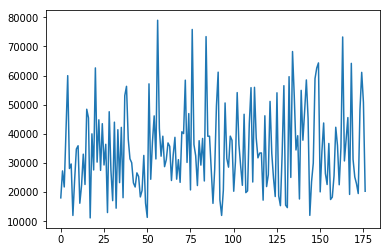

##### Smoothed Training Loss Curve

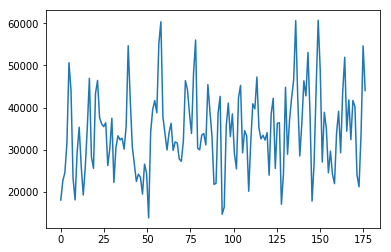

##### Smoothed and Zoomed Training Loss Curve

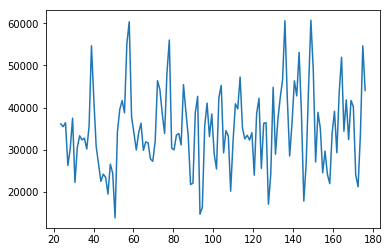

#### Test Error

* Baseline Loss: 1676.98

* Model Loss: 34483.39

## Experiment Summary: mvp2

### Characteristics

* Bins: Offer values rounded to every even 50 cent [3, 1000] in symmetric 25 cent window around each rounding target

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Only offer history and starting price included as features. Training stopped after drawingminibatches (with replacement) equivalent to 20 times the size of the data.

### Model for offr_s0 incomplete

### Model for offr_s1 incomplete

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

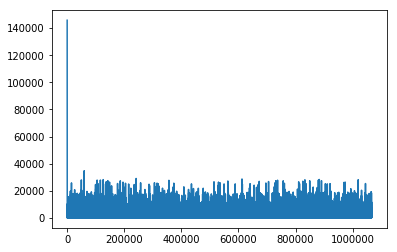

##### Smoothed Training Loss Curve

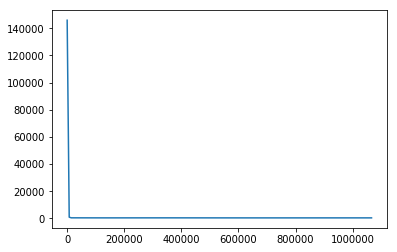

##### Smoothed and Zoomed Training Loss Curve

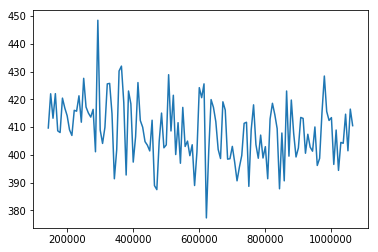

#### Test Error

* Baseline Loss: 1676.98

* Model Loss: 410.78

## Experiment Summary: mvp3

### Characteristics

* Bins: Offer values rounded to 1% of most common values observed for offer being predicted provided that the center of each bin is at least 50 cents from the center of adjacent bins -- this requirement reduces the number of bins to approximately 170 from about 500

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Offer history, buyer feedback scores, fraction of auction remaining at time of offer, time (in hours) each player took to make hitherto observed offers, number of previous threads buyer and seller have engaged in, indicators for item category, and quality. Training stopped afterdrawing minibatches (with replacement) equivalent to 5 times the size of the data

### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

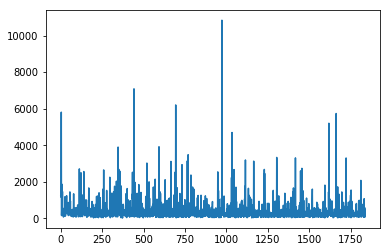

##### Smoothed Training Loss Curve

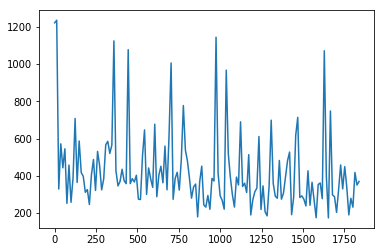

##### Smoothed and Zoomed Training Loss Curve

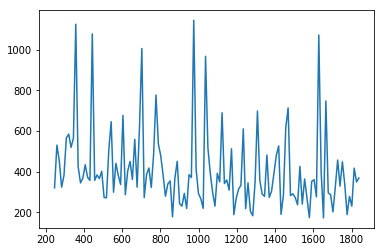

#### Test Error

* Baseline Loss: 2022.99

* Model Loss: 442.81

### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

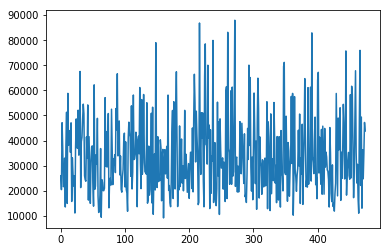

##### Smoothed Training Loss Curve

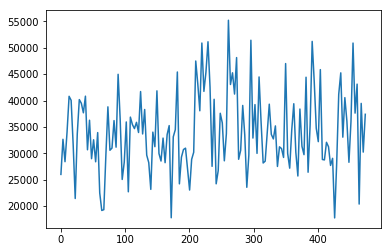

##### Smoothed and Zoomed Training Loss Curve

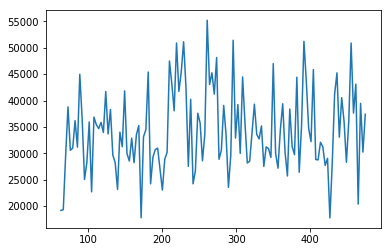

#### Test Error

* Baseline Loss: 1654.79

* Model Loss: 33360.55

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

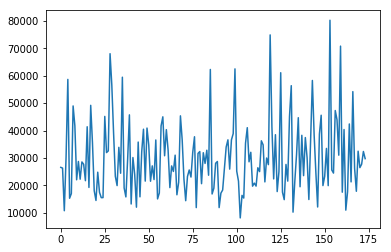

##### Smoothed Training Loss Curve

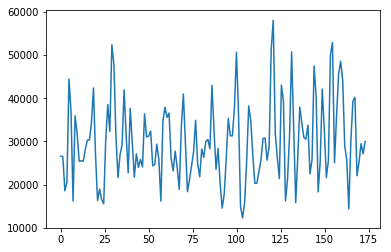

##### Smoothed and Zoomed Training Loss Curve

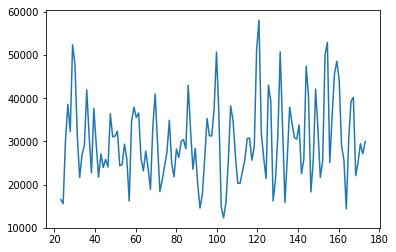

#### Test Error

* Baseline Loss: 1481.63

* Model Loss: 30654.60

## Experiment Summary: mvp4

### Characteristics

* Bins: Offer values rounded to 1% of most common values observed for offer being predicted provided that the center of each bin is at least 50 cents from the center of adjacent bins -- this requirement reduces the number of bins to approximately 170 from about 500

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Only offer history and starting price included as features. Training stopped after drawingminibatches (with replacement) equivalent to 20 times the size of the data.

### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

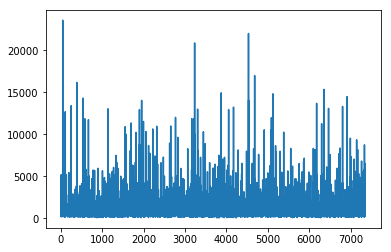

##### Smoothed Training Loss Curve

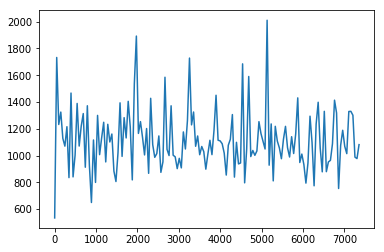

##### Smoothed and Zoomed Training Loss Curve

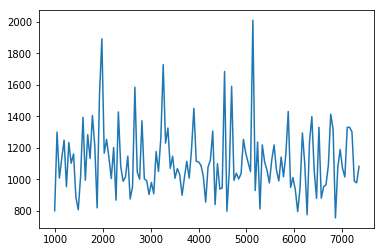

#### Test Error

* Baseline Loss: 2023.12

* Model Loss: 1107.40

### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

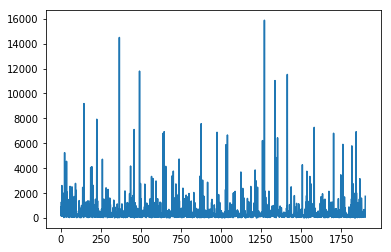

##### Smoothed Training Loss Curve

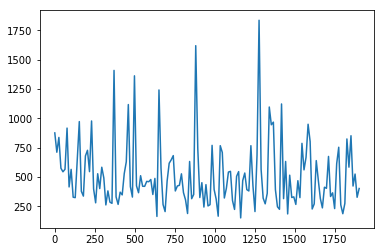

##### Smoothed and Zoomed Training Loss Curve

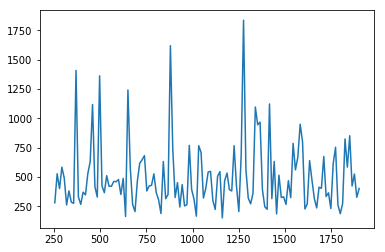

#### Test Error

* Baseline Loss: 1654.75

* Model Loss: 472.89

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

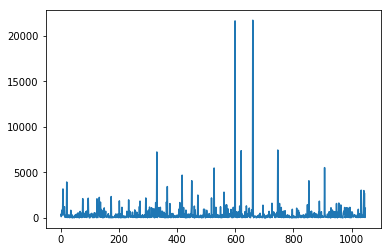

##### Smoothed Training Loss Curve

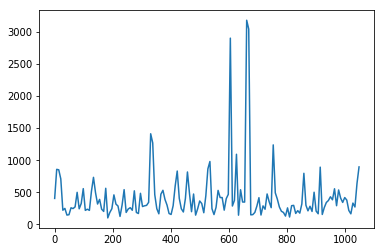

##### Smoothed and Zoomed Training Loss Curve

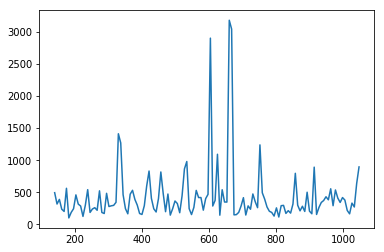

#### Test Error

* Baseline Loss: 1481.63

* Model Loss: 365.76

## Experiment Summary: crossent_simp_1

### Characteristics

* Bins: Offer values rounded to every even 50 cent [3, 1000] in symmetric 25 cent window around each rounding target

* Complexity: 1 non-linear activation layer containing 30 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Offer history, buyer feedback scores, fraction of auction remaining at time of offer, time (in hours) each player took to make hitherto observed offers, number of previous threads buyer and seller have engaged in, indicators for item category, and quality. Training stopped afterdrawing minibatches (with replacement) equivalent to 5 times the size of the data

### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

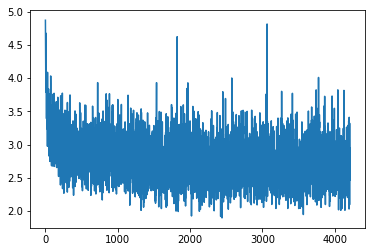

##### Smoothed Training Loss Curve

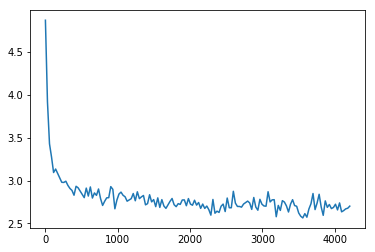

##### Smoothed and Zoomed Training Loss Curve

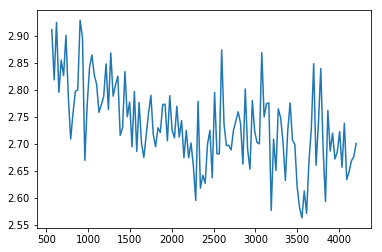

#### Test Error

* Baseline Loss: 1840.36

* Model Loss: 702.17

### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

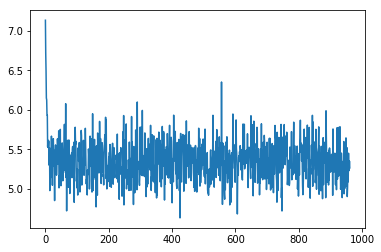

##### Smoothed Training Loss Curve

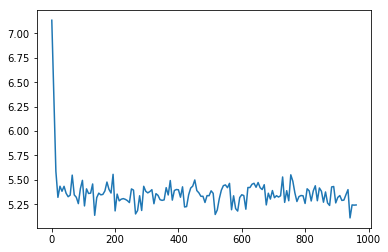

##### Smoothed and Zoomed Training Loss Curve

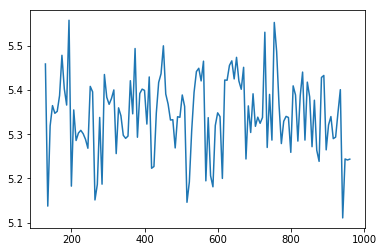

#### Test Error

* Baseline Loss: 1679.66

* Model Loss: 45736.52

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

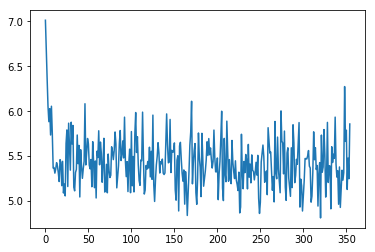

##### Smoothed Training Loss Curve

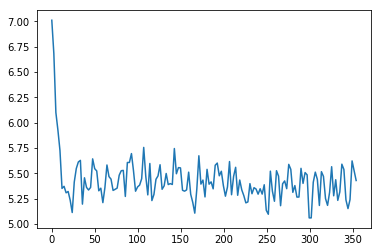

##### Smoothed and Zoomed Training Loss Curve

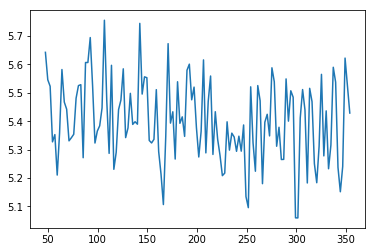

#### Test Error

* Baseline Loss: 1676.98

* Model Loss: 47824.29

## Experiment Summary: crossent_simp_2

### Characteristics

* Bins: Offer values rounded to every even 50 cent [3, 1000] in symmetric 25 cent window around each rounding target

* Complexity: 1 non-linear activation layer containing 30 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Only offer history and starting price included as features. Training stopped after drawingminibatches (with replacement) equivalent to 20 times the size of the data.

### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

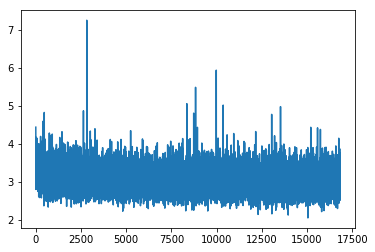

##### Smoothed Training Loss Curve

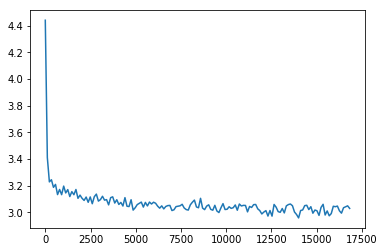

##### Smoothed and Zoomed Training Loss Curve

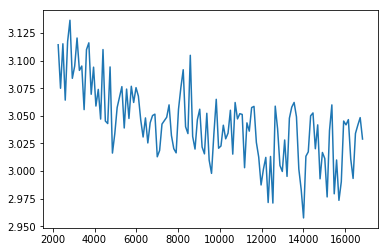

#### Test Error

* Baseline Loss: 1840.46

* Model Loss: 1638.00

### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

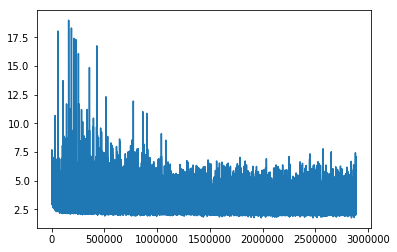

##### Smoothed Training Loss Curve

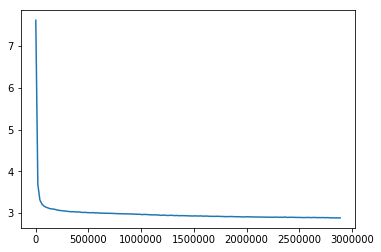

##### Smoothed and Zoomed Training Loss Curve

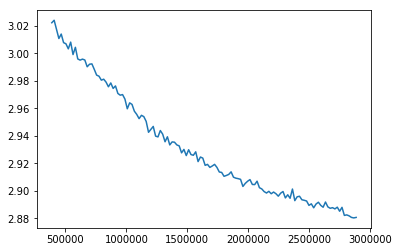

#### Test Error

* Baseline Loss: 1679.65

* Model Loss: 645.40

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

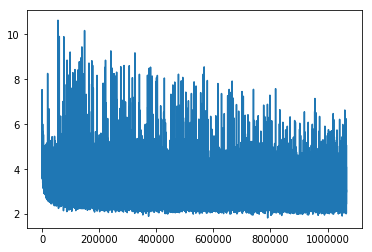

##### Smoothed Training Loss Curve

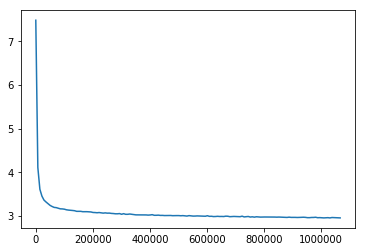

##### Smoothed and Zoomed Training Loss Curve

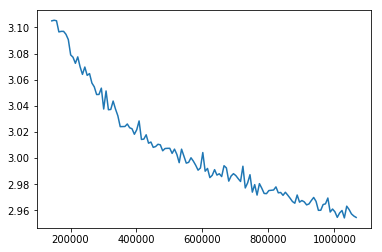

#### Test Error

* Baseline Loss: 1676.98

* Model Loss: 633.17

## Experiment Summary: crossent_simp_3

### Characteristics

* Bins: Offer values rounded to 1% of most common values observed for offer being predicted provided that the center of each bin is at least 50 cents from the center of adjacent bins -- this requirement reduces the number of bins to approximately 170 from about 500

* Complexity: 1 non-linear activation layer containing 30 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Offer history, buyer feedback scores, fraction of auction remaining at time of offer, time (in hours) each player took to make hitherto observed offers, number of previous threads buyer and seller have engaged in, indicators for item category, and quality. Training stopped afterdrawing minibatches (with replacement) equivalent to 5 times the size of the data

### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

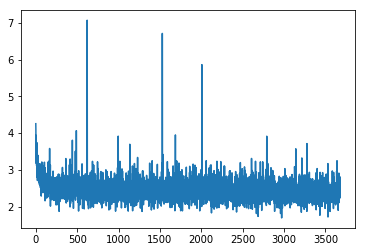

##### Smoothed Training Loss Curve

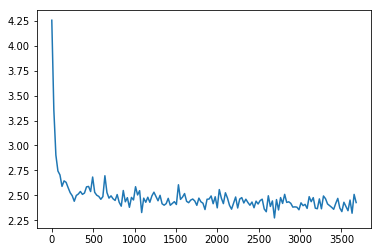

##### Smoothed and Zoomed Training Loss Curve

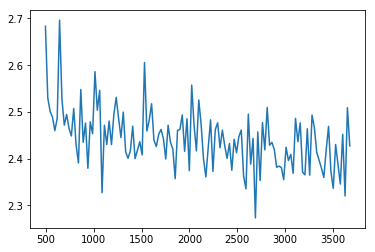

#### Test Error

* Baseline Loss: 2022.99

* Model Loss: 775.66

### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

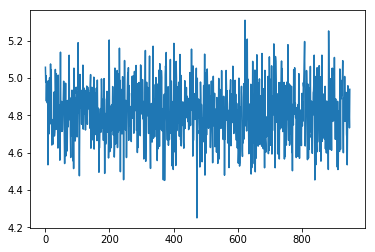

##### Smoothed Training Loss Curve

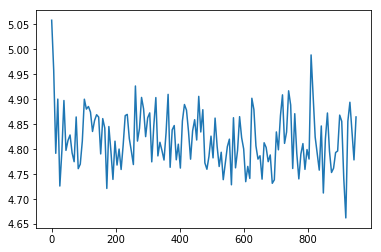

##### Smoothed and Zoomed Training Loss Curve

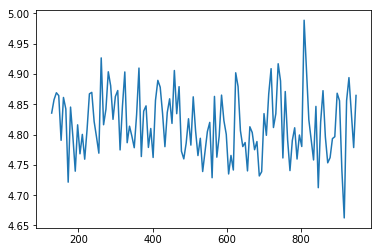

#### Test Error

* Baseline Loss: 1654.79

* Model Loss: 49860.81

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

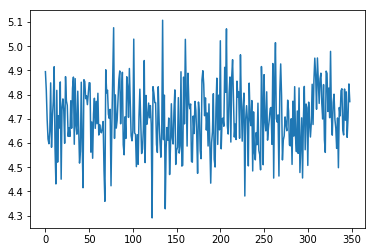

##### Smoothed Training Loss Curve

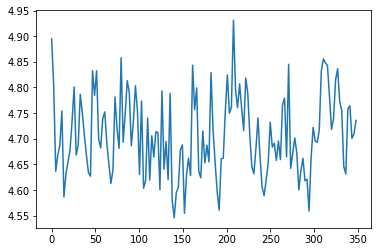

##### Smoothed and Zoomed Training Loss Curve

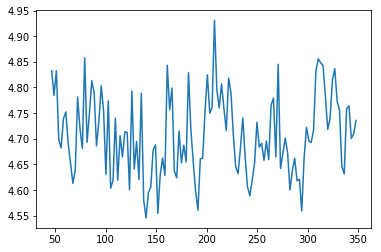

#### Test Error

* Baseline Loss: 1481.63

* Model Loss: 43008.26

## Experiment Summary: crossent_simp_4

### Characteristics

* Bins: Offer values rounded to 1% of most common values observed for offer being predicted provided that the center of each bin is at least 50 cents from the center of adjacent bins -- this requirement reduces the number of bins to approximately 170 from about 500

* Complexity: 1 non-linear activation layer containing 30 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Only offer history and starting price included as features. Training stopped after drawingminibatches (with replacement) equivalent to 20 times the size of the data.

### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

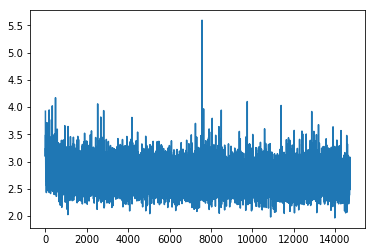

##### Smoothed Training Loss Curve

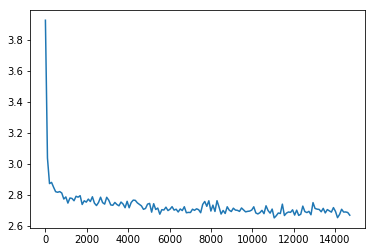

##### Smoothed and Zoomed Training Loss Curve

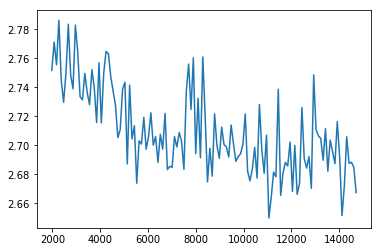

#### Test Error

* Baseline Loss: 2023.12

* Model Loss: 1479.65

### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

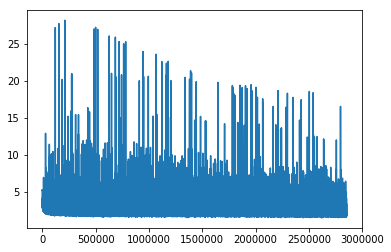

##### Smoothed Training Loss Curve

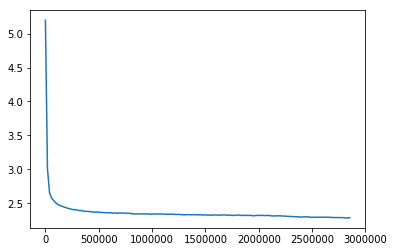

##### Smoothed and Zoomed Training Loss Curve

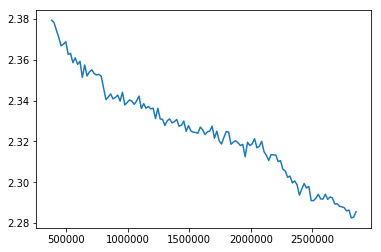

#### Test Error

* Baseline Loss: 1654.75

* Model Loss: 642.60

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

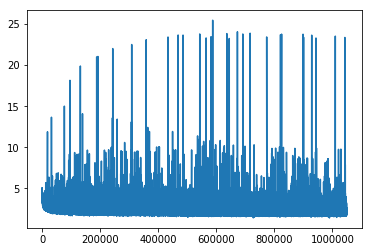

##### Smoothed Training Loss Curve

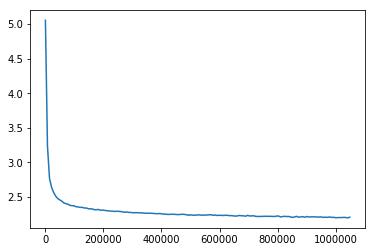

##### Smoothed and Zoomed Training Loss Curve

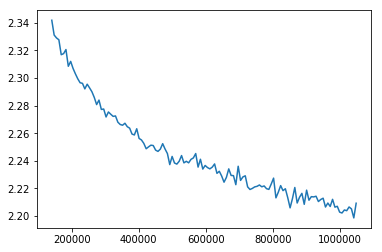

#### Test Error

* Baseline Loss: 1481.63

* Model Loss: 512.40

## Experiment Summary: crossent_comp_1

### Characteristics

* Bins: Offer values rounded to every even 50 cent [3, 1000] in symmetric 25 cent window around each rounding target

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Offer history, buyer feedback scores, fraction of auction remaining at time of offer, time (in hours) each player took to make hitherto observed offers, number of previous threads buyer and seller have engaged in, indicators for item category, and quality. Training stopped afterdrawing minibatches (with replacement) equivalent to 5 times the size of the data

### Model for offr_s0 incomplete

### Model for offr_s1 incomplete

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

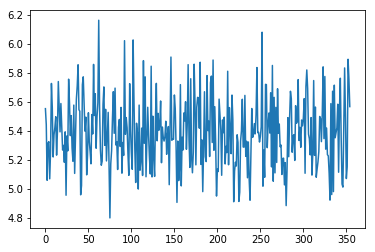

##### Smoothed Training Loss Curve

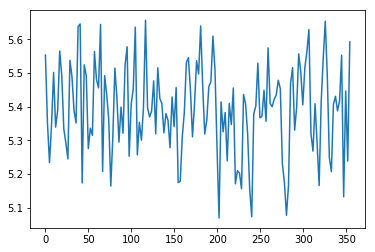

##### Smoothed and Zoomed Training Loss Curve

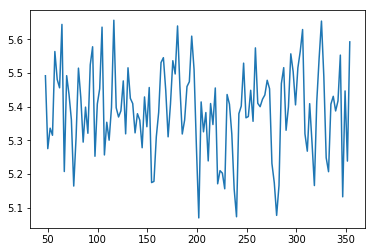

#### Test Error

* Baseline Loss: 1676.98

* Model Loss: 45612.73

## Experiment Summary: crossent_comp_2

### Characteristics

* Bins: Offer values rounded to every even 50 cent [3, 1000] in symmetric 25 cent window around each rounding target

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Only offer history and starting price included as features. Training stopped after drawingminibatches (with replacement) equivalent to 20 times the size of the data.

### Model for offr_s0 incomplete

### Model for offr_s1 incomplete

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

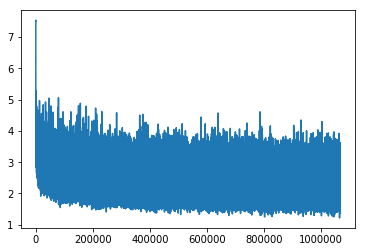

##### Smoothed Training Loss Curve

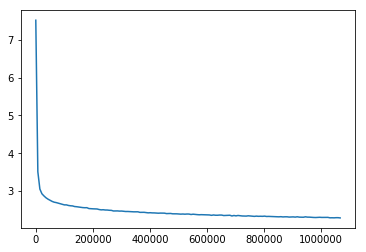

##### Smoothed and Zoomed Training Loss Curve

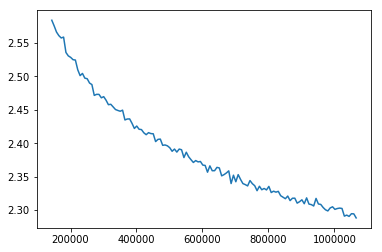

#### Test Error

* Baseline Loss: 1676.98

* Model Loss: 542.37

## Experiment Summary: crossent_comp_3

### Characteristics

* Bins: Offer values rounded to 1% of most common values observed for offer being predicted provided that the center of each bin is at least 50 cents from the center of adjacent bins -- this requirement reduces the number of bins to approximately 170 from about 500

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Offer history, buyer feedback scores, fraction of auction remaining at time of offer, time (in hours) each player took to make hitherto observed offers, number of previous threads buyer and seller have engaged in, indicators for item category, and quality. Training stopped afterdrawing minibatches (with replacement) equivalent to 5 times the size of the data

### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

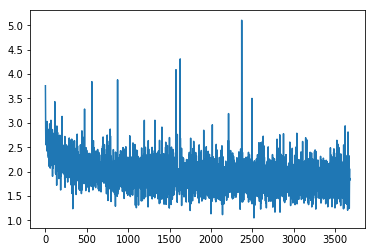

##### Smoothed Training Loss Curve

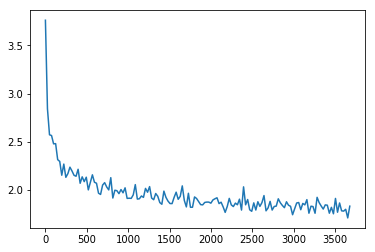

##### Smoothed and Zoomed Training Loss Curve

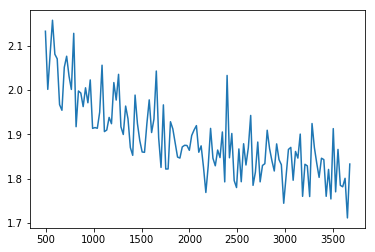

#### Test Error

* Baseline Loss: 2022.99

* Model Loss: 655.75

### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

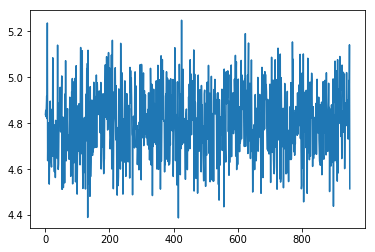

##### Smoothed Training Loss Curve

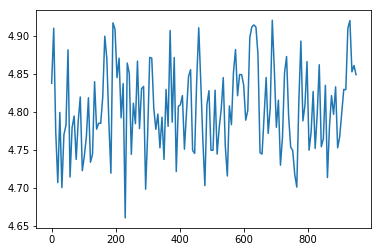

##### Smoothed and Zoomed Training Loss Curve

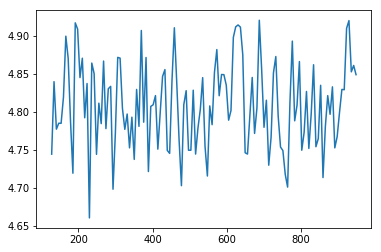

#### Test Error

* Baseline Loss: 1654.79

* Model Loss: 43083.85

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

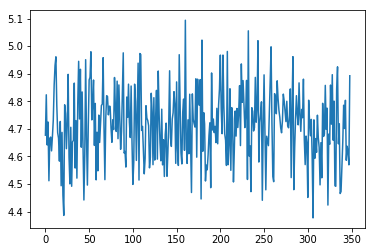

##### Smoothed Training Loss Curve

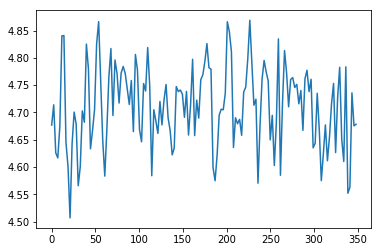

##### Smoothed and Zoomed Training Loss Curve

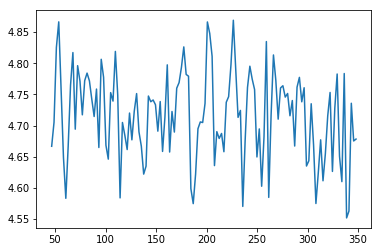

#### Test Error

* Baseline Loss: 1481.63

* Model Loss: 43008.26

## Experiment Summary: crossent_comp_4

### Characteristics

* Bins: Offer values rounded to 1% of most common values observed for offer being predicted provided that the center of each bin is at least 50 cents from the center of adjacent bins -- this requirement reduces the number of bins to approximately 170 from about 500

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Only offer history and starting price included as features. Training stopped after drawingminibatches (with replacement) equivalent to 20 times the size of the data.

### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

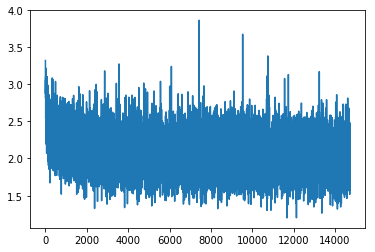

##### Smoothed Training Loss Curve

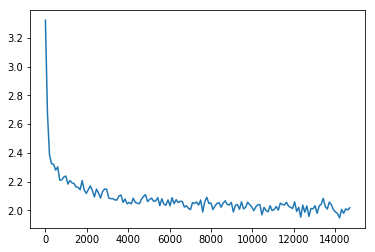

##### Smoothed and Zoomed Training Loss Curve

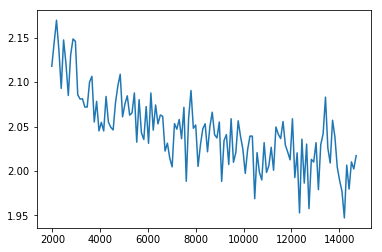

#### Test Error

* Baseline Loss: 2023.12

* Model Loss: 1715.05

### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

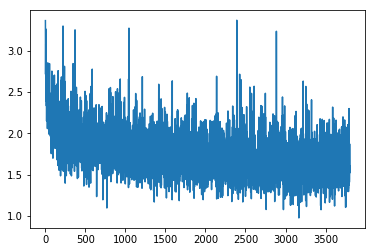

##### Smoothed Training Loss Curve

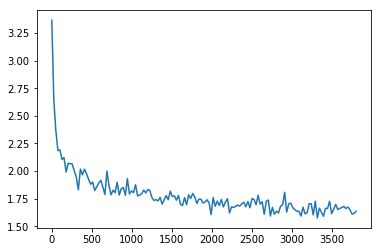

##### Smoothed and Zoomed Training Loss Curve

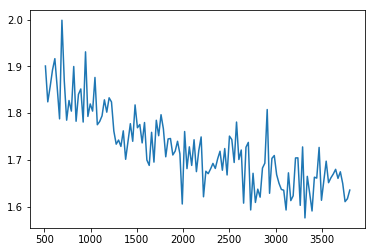

#### Test Error

* Baseline Loss: 1654.75

* Model Loss: 620.13

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

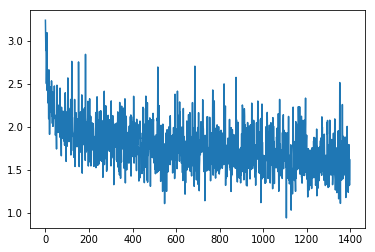

##### Smoothed Training Loss Curve

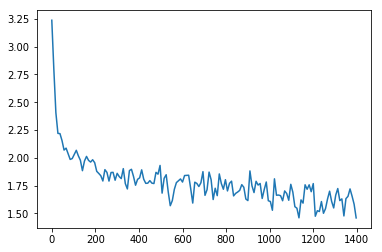

##### Smoothed and Zoomed Training Loss Curve

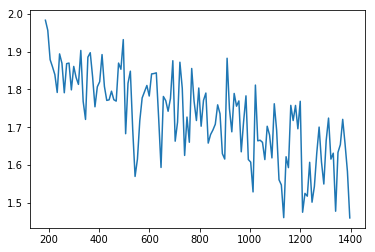

#### Test Error

* Baseline Loss: 1481.63

* Model Loss: 546.54

## Experiment Summary: exp_simp_1

### Characteristics

* Bins: Offer values rounded to every even 50 cent [3, 1000] in symmetric 25 cent window around each rounding target

* Complexity: 1 non-linear activation layer containing 30 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Offer history, buyer feedback scores, fraction of auction remaining at time of offer, time (in hours) each player took to make hitherto observed offers, number of previous threads buyer and seller have engaged in, indicators for item category, and quality. Training stopped afterdrawing minibatches (with replacement) equivalent to 5 times the size of the data

### Model for offr_s0 incomplete

### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

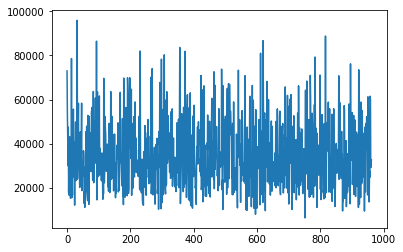

##### Smoothed Training Loss Curve

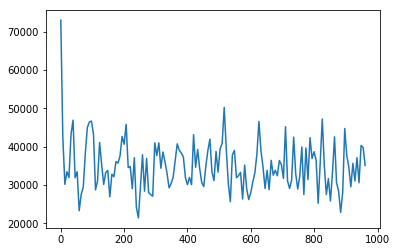

##### Smoothed and Zoomed Training Loss Curve

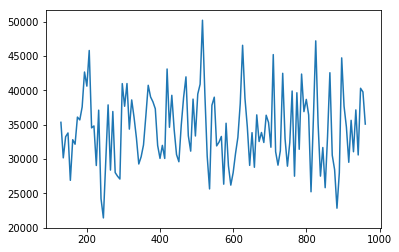

#### Test Error

* Baseline Loss: 1679.66

* Model Loss: 34041.45

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

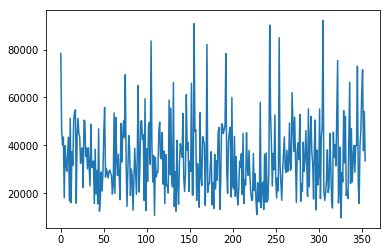

##### Smoothed Training Loss Curve

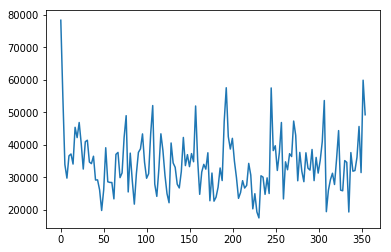

##### Smoothed and Zoomed Training Loss Curve

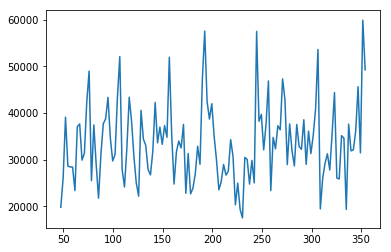

#### Test Error

* Baseline Loss: 1676.98

* Model Loss: 34472.05

## Experiment Summary: exp_simp_2

### Characteristics

* Bins: Offer values rounded to every even 50 cent [3, 1000] in symmetric 25 cent window around each rounding target

* Complexity: 1 non-linear activation layer containing 30 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Only offer history and starting price included as features. Training stopped after drawingminibatches (with replacement) equivalent to 20 times the size of the data.

### Model for offr_s0 incomplete

### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

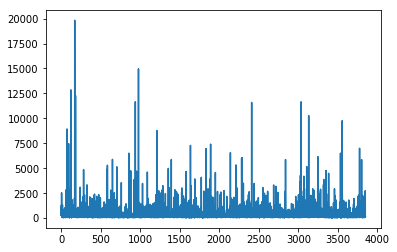

##### Smoothed Training Loss Curve

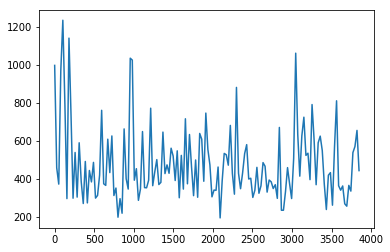

##### Smoothed and Zoomed Training Loss Curve

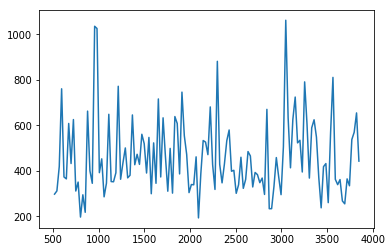

#### Test Error

* Baseline Loss: 1679.65

* Model Loss: 479.88

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

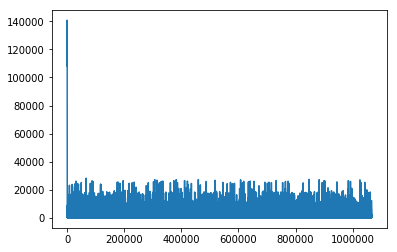

##### Smoothed Training Loss Curve

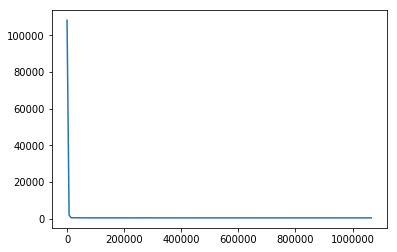

##### Smoothed and Zoomed Training Loss Curve

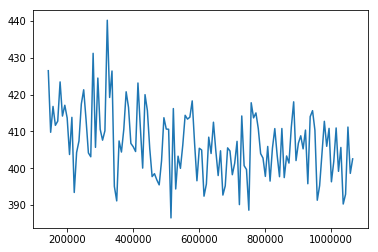

#### Test Error

* Baseline Loss: 1676.98

* Model Loss: 417.27

## Experiment Summary: exp_simp_3

### Characteristics

* Bins: Offer values rounded to 1% of most common values observed for offer being predicted provided that the center of each bin is at least 50 cents from the center of adjacent bins -- this requirement reduces the number of bins to approximately 170 from about 500

* Complexity: 1 non-linear activation layer containing 30 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Offer history, buyer feedback scores, fraction of auction remaining at time of offer, time (in hours) each player took to make hitherto observed offers, number of previous threads buyer and seller have engaged in, indicators for item category, and quality. Training stopped afterdrawing minibatches (with replacement) equivalent to 5 times the size of the data

### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

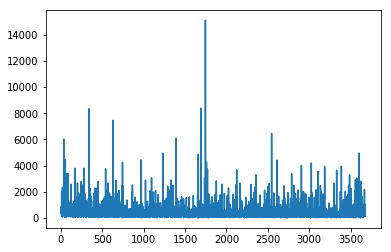

##### Smoothed Training Loss Curve

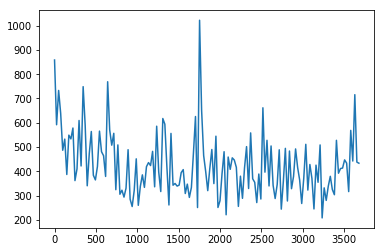

##### Smoothed and Zoomed Training Loss Curve

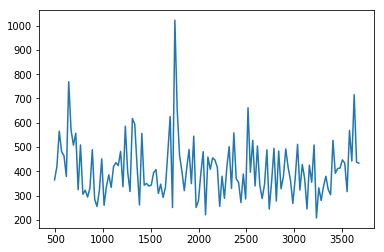

#### Test Error

* Baseline Loss: 2022.99

* Model Loss: 419.57

### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

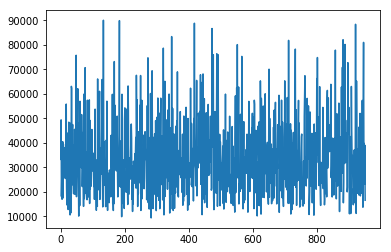

##### Smoothed Training Loss Curve

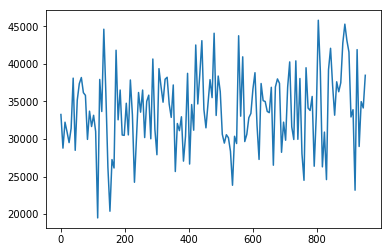

##### Smoothed and Zoomed Training Loss Curve

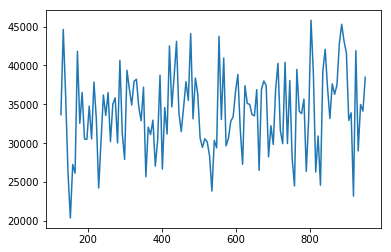

#### Test Error

* Baseline Loss: 1654.79

* Model Loss: 33361.19

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

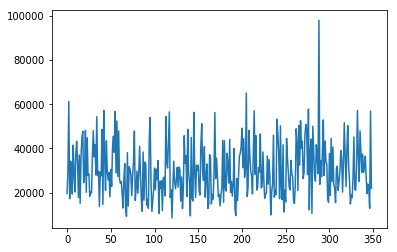

##### Smoothed Training Loss Curve

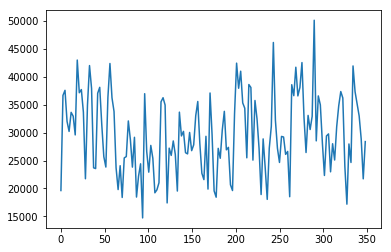

##### Smoothed and Zoomed Training Loss Curve

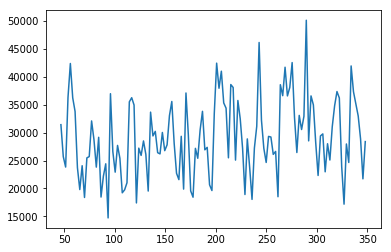

#### Test Error

* Baseline Loss: 1481.63

* Model Loss: 30643.72

## Experiment Summary: exp_simp_4

### Characteristics

* Bins: Offer values rounded to 1% of most common values observed for offer being predicted provided that the center of each bin is at least 50 cents from the center of adjacent bins -- this requirement reduces the number of bins to approximately 170 from about 500

* Complexity: 1 non-linear activation layer containing 30 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Only offer history and starting price included as features. Training stopped after drawingminibatches (with replacement) equivalent to 20 times the size of the data.

### Analysis of Model for offr_s0

#### Training Curves

##### Raw Training Loss Curve

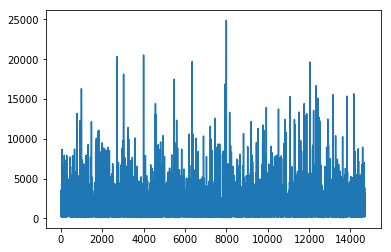

##### Smoothed Training Loss Curve

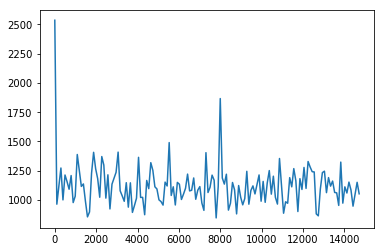

##### Smoothed and Zoomed Training Loss Curve

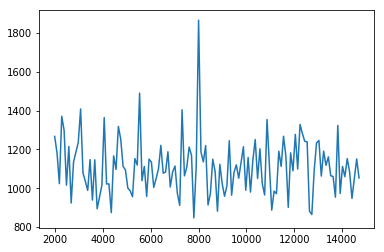

#### Test Error

* Baseline Loss: 2023.12

* Model Loss: 1107.75

### Analysis of Model for offr_s1

#### Training Curves

##### Raw Training Loss Curve

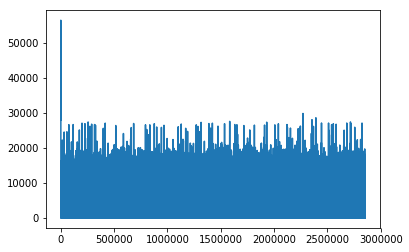

##### Smoothed Training Loss Curve

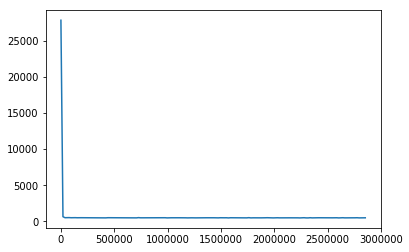

##### Smoothed and Zoomed Training Loss Curve

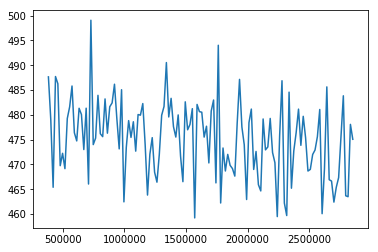

#### Test Error

* Baseline Loss: 1654.75

* Model Loss: 468.07

### Analysis of Model for offr_s2

#### Training Curves

##### Raw Training Loss Curve

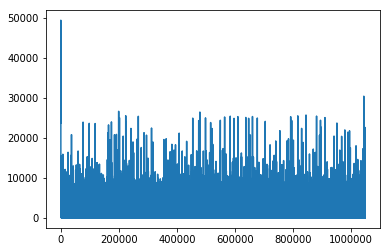

##### Smoothed Training Loss Curve

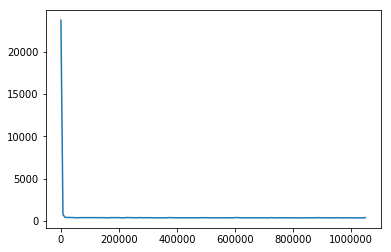

##### Smoothed and Zoomed Training Loss Curve

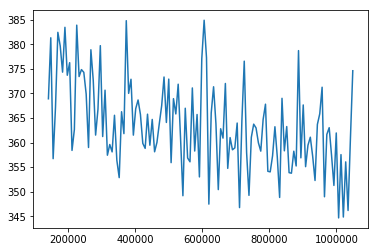

#### Test Error

* Baseline Loss: 1481.63

* Model Loss: 367.79

offr_s0|offr_s1|offr_s2|model
---|---|---|---
1840.3638916015625|1679.6640625|1676.9764404296875|base_even_bins
2022.9949951171875|1654.7880859375|1481.6279296875|base_common_bins
||34483.39453125|mvp1
||410.7781066894531|mvp2
442.8064880371094|33360.546875|30654.599609375|mvp3
1107.40234375|472.8887023925781|365.75994873046875|mvp4
702.1748046875|45736.51953125|47824.28515625|crossent_simp_1
1638.0030517578125|645.3965454101562|633.1724853515625|crossent_simp_2
775.6615600585938|49860.80859375|43008.2578125|crossent_simp_3
1479.649169921875|642.5999145507812|512.3960571289062|crossent_simp_4
||45612.73046875|crossent_comp_1
||542.3716430664062|crossent_comp_2
655.7476806640625|43083.84765625|43008.2578125|crossent_comp_3
1715.0546875|620.129150390625|546.5368041992188|crossent_comp_4
|34041.453125|34472.05078125|exp_simp_1
|479.8795471191406|417.2745666503906|exp_simp_2
419.57379150390625|33361.1875|30643.724609375|exp_simp_3
1107.746337890625|468.0726013183594|367.79327392578125|exp_simp_4


In [64]:
main()